In [9]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from scipy.stats import randint
import joblib
from sklearn.ensemble import RandomForestRegressor

In [10]:
cod = pd.read_csv("cod.csv")
cod = cod.drop('name', axis=1)
print(cod.head())
print(cod.shape)

   wins  kills  kdRatio  killstreak  level  losses  prestige  hits  \
0     0      0  0.00000           0      1       0         0     0   
1     0      0  0.00000           0      1       0       110     0   
2     0     66  1.03125           0      9       0       110     0   
3     3      2  0.40000           0      1       0         0     0   
4     0      2  0.20000           0      1       0       110     0   

   timePlayed  headshots  averageTime  gamesPlayed  assists  misses     xp  \
0           0          0          0.0            0        0       0      0   
1           7          0          7.0            0        0       0    700   
2          32         16         32.0            0        1       0  48300   
3           3          0          3.0            0        0       0   1150   
4           5          1          5.0            0        0       0   1000   

   scorePerMinute  shots  deaths  
0             0.0      0       0  
1             0.0      0      16  
2    

In [11]:
print(cod.describe())

              wins         kills      kdRatio   killstreak        level  \
count  1558.000000   1558.000000  1558.000000  1558.000000  1558.000000   
mean    153.002567   3753.001926     0.637098     6.895379    44.414634   
std     301.984766   7929.696675     0.430459    10.184677    68.318064   
min       0.000000      0.000000     0.000000     0.000000     1.000000   
25%       0.000000      4.000000     0.261442     0.000000     1.000000   
50%      10.000000    191.500000     0.732837     5.000000    11.000000   
75%     168.000000   3445.750000     0.955293    12.000000    51.000000   
max    3519.000000  66935.000000     3.000000   235.000000   435.000000   

            losses     prestige           hits   timePlayed     headshots  \
count  1558.000000  1558.000000    1558.000000  1558.000000   1558.000000   
mean      4.998074    47.657253   10330.189987   425.915918    630.672657   
std       7.005778    51.626213   22954.104384   786.182499   1305.150393   
min       0.0000

In [12]:
# Calculate Accuracy by dividing hits by shots, handling division by zero
mask = cod['shots'] != 0  # Create a mask for non-zero shots
cod.loc[mask, 'Accuracy'] = cod['hits'] / cod['shots']
cod.loc[~mask, 'Accuracy'] = pd.NA  # Set Accuracy to pd.NA for zero shots

# Calculate Headshot Ratio by dividing headshots by kills, handling division by zero
mask = cod['kills'] != 0  # Create a mask for non-zero shots
cod.loc[mask, 'Headshot Ratio'] = cod['headshots'] / cod['kills']
cod.loc[~mask, 'Headshot Ratio'] = pd.NA  # Set Accuracy to pd.NA for zero shots

print(cod.columns)

Index(['wins', 'kills', 'kdRatio', 'killstreak', 'level', 'losses', 'prestige',
       'hits', 'timePlayed', 'headshots', 'averageTime', 'gamesPlayed',
       'assists', 'misses', 'xp', 'scorePerMinute', 'shots', 'deaths',
       'Accuracy', 'Headshot Ratio'],
      dtype='object')


RANDOM FOREST ROUND 1

In [13]:
X = cod.drop('wins', axis=1)
y = cod['wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [14]:
# Update the pipeline to use RandomForestRegressor
rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('standard', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=0))
])

In [15]:
# Define the parameter space for RandomizedSearchCV
param_distributions = {
    'rf__n_estimators': randint(100, 500),  # Number of trees in the forest
    'rf__max_depth': randint(3, 20),  # Maximum depth of the tree
}

In [16]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings that are sampled. 
    cv=5,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',  
    random_state=102,
    verbose=1
)

In [17]:
# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('impute',
                                              SimpleImputer(strategy='median')),
                                             ('poly',
                                              PolynomialFeatures(degree=1,
                                                                 include_bias=False)),
                                             ('standard', StandardScaler()),
                                             ('rf',
                                              RandomForestRegressor(random_state=0))]),
                   param_distributions={'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x147e9ff40>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156243ac0>},
                   random_state=102, scoring='neg_mean_squared_error',
                   verbose=1)

In [18]:

# Predict on the training set
y_train_pred = random_search.predict(X_train)

# Predict on the test set
y_test_pred = random_search.predict(X_test)

# Calculate RMSE for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training Root Mean Squared Error: {rmse_train}")

# Calculate RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Testing Root Mean Squared Error: {rmse_test}")

Training Root Mean Squared Error: 36.51065384259979
Testing Root Mean Squared Error: 78.97200923214908


In [33]:
# Define the parameter space for RandomizedSearchCV
param_distributions = {
    'rf__n_estimators': randint(150, 500),  # More trees
    'rf__max_depth': randint(5, 15),  # Reduce maximum depth to prevent complex models
    'rf__min_samples_leaf': randint(4, 12),  # More samples per leaf
    'rf__min_samples_split': randint(10, 20),  # More samples needed to split
    'rf__max_features': ['auto', 'sqrt', 'log2'],  # Consider fewer features per split
}

# Prepare data
X = cod.drop('wins', axis=1)
y = cod['wins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Update the RandomForestRegressor pipeline
rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('standard', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=0))
])

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=10,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',  
    random_state=102,
    verbose=1
)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Predict and evaluate
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training Root Mean Squared Error: {rmse_train}")
print(f"Testing Root Mean Squared Error: {rmse_test}")


Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Users/tylersmith/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
120 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tylersmith/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tylersmith/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/tylersmith/anaconda3/envs/new/lib/python3.10/site-packages/sklearn/pipeline.py", l

Training Root Mean Squared Error: 83.1150434601963
Testing Root Mean Squared Error: 90.53441283953376


In [35]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
import numpy as np
import pandas as pd

# Assuming the data is loaded in the DataFrame 'cod'
# Prepare data
X = cod.drop('wins', axis=1)
y = cod['wins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Update the RandomForestRegressor pipeline
rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('standard', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=0))
])

# Define the parameter space for RandomizedSearchCV
param_distributions = {
    'rf__n_estimators': randint(150, 500),  # More trees
    'rf__max_depth': randint(5, 15),  # Reduce maximum depth to prevent complex models
    'rf__min_samples_leaf': randint(4, 12),  # More samples per leaf
    'rf__min_samples_split': randint(10, 20),  # More samples needed to split
    'rf__max_features': ['sqrt', 'log2'],  # Valid options for max_features
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=10,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',  
    random_state=102,
    verbose=1
)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Predict and evaluate
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print RMSE values
print(f"Training Root Mean Squared Error: {rmse_train}")
print(f"Testing Root Mean Squared Error: {rmse_test}")

# Print the best parameters
best_parameters = random_search.best_params_
print("Best parameters found: ", best_parameters)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Training Root Mean Squared Error: 79.2818661625855
Testing Root Mean Squared Error: 89.33050632881843
Best parameters found:  {'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 12, 'rf__n_estimators': 202}


RANDOM FOREST ROUND 2

In [19]:
param_distributions = {
    'rf__n_estimators': randint(50, 200),  # Fewer trees
    'rf__max_depth': randint(3, 10),  # Shallower trees
    'rf__min_samples_split': randint(2, 10),  # More samples needed to split
    'rf__min_samples_leaf': randint(1, 10),  # More samples needed at leaf nodes
    'rf__max_features': ['sqrt', 0.25, 0.5],  # Less features considered at each split
}

In [20]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings that are sampled. 
    cv=5,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',  
    random_state=0,
    verbose=1
)

In [21]:
# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('impute',
                                              SimpleImputer(strategy='median')),
                                             ('poly',
                                              PolynomialFeatures(degree=1,
                                                                 include_bias=False)),
                                             ('standard', StandardScaler()),
                                             ('rf',
                                              RandomForestRegressor(random_state=0))]),
                   param_distributions={'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x152db7e80>,
                                        'rf__max_fe...5],
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156136500>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156136290>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156136bf0>},
                   random_state=0, scoring='neg_mean_squared_error', verbose=1)

In [22]:
# Predict on the training set
y_train_pred = random_search.predict(X_train)

# Predict on the test set
y_test_pred = random_search.predict(X_test)

# Calculate RMSE for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training Root Mean Squared Error: {rmse_train}")

# Calculate RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Testing Root Mean Squared Error: {rmse_test}")

# Comparing the RMSEs to check if the test MSE is "better" (lower) than the training MSE
if rmse_test < rmse_train:
    print("The testing RMSE is better (lower) than the training MSE.")
else:
    print("The testing RMSE is not better (higher) than the training MSE.")

Training Root Mean Squared Error: 42.9786592141681
Testing Root Mean Squared Error: 80.13398281884199
The testing RMSE is not better (higher) than the training MSE.


Random Forest Round 3

In [23]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=10,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',  
    random_state=102,
    verbose=1
)

In [24]:

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('impute',
                                              SimpleImputer(strategy='median')),
                                             ('poly',
                                              PolynomialFeatures(degree=1,
                                                                 include_bias=False)),
                                             ('standard', StandardScaler()),
                                             ('rf',
                                              RandomForestRegressor(random_state=0))]),
                   n_iter=20,
                   param_distributions={'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x152db7e80>,
                                        'rf__max_features': ['sqrt', 0.25, 0.5],
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156136500>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156136290>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156136bf0>},
                   random_state=102, scoring='neg_mean_squared_error',
                   verbose=1)

In [25]:
# Predict and evaluate
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training Root Mean Squared Error: {rmse_train}")
print(f"Testing Root Mean Squared Error: {rmse_test}")

Training Root Mean Squared Error: 66.97989346765449
Testing Root Mean Squared Error: 83.37977386439469


Random Forest Round 4

Clustering

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Apply the imputer to the data
cod_imputed = imputer.fit_transform(cod)

# Now scale the imputed data
scaler = StandardScaler()
cod_scaled = scaler.fit_transform(cod_imputed)

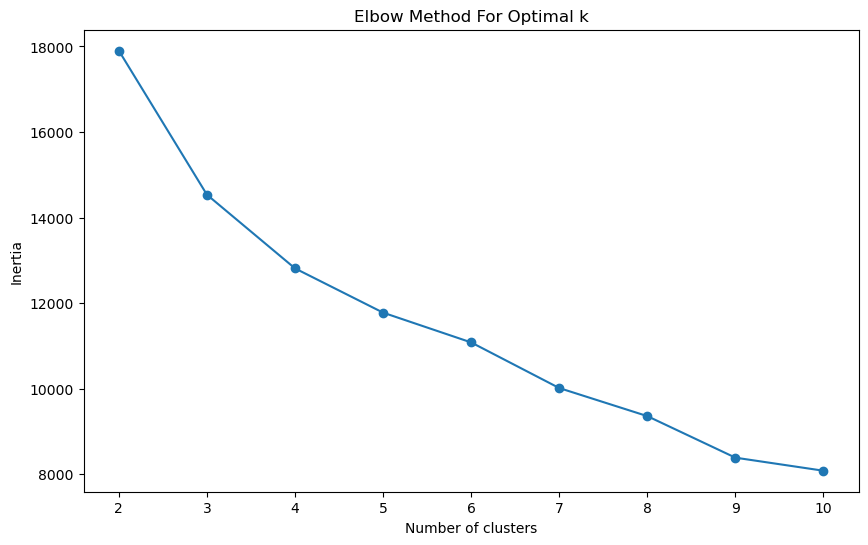

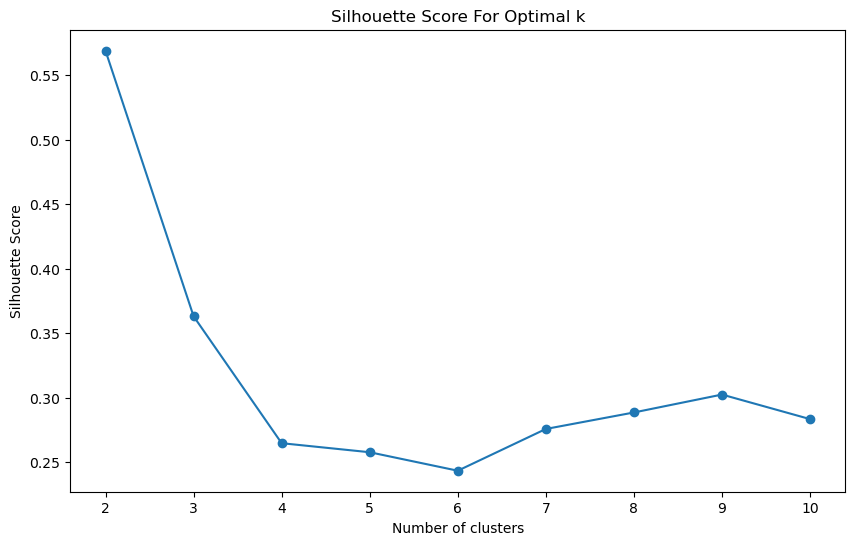

In [27]:
# Proceed with the Elbow Method and Silhouette Scores using cod_scaled
inertias = []
silhouette_scores = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cod_scaled)
    inertias.append(kmeans.inertia_)
    # Computing silhouette score can be expensive for large datasets, consider commenting this out if not needed
    silhouette_scores.append(silhouette_score(cod_scaled, kmeans.labels_))

# Plotting the Elbow Plot
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertias, '-o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores for comparison
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores, '-o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()



In [28]:
# Determine the optimal number of clusters based on the Elbow method and Silhouette score
k_optimal = 3  

# Apply K-means with the optimal number of clusters
kmeans_final = KMeans(n_clusters=k_optimal, random_state=0)
clusters = kmeans_final.fit_predict(cod_scaled)

# Add the cluster labels to the DataFrame for analysis
cod['Cluster'] = clusters

# Analyze the clusters by looking at the mean values of features in each cluster
cluster_means = cod.groupby('Cluster').mean()

# Now print the cluster means for interpretation
# Note: Depending on the size of cluster_means, you might need to print subsets of it
print(cluster_means)
#cluster_means.to_csv('cluster_means.csv')

                wins         kills   kdRatio  killstreak       level  \
Cluster                                                                
0          23.699650    376.099825  0.506958    3.401051   12.106830   
1        1036.210526  28895.968421  1.010292   20.389474  223.063158   
2         351.629283   8325.713396  0.989642   15.333333  106.482866   

            losses   prestige          hits   timePlayed    headshots  \
Cluster                                                                 
0         2.037653  33.399299    948.237303    82.588441    66.046410   
1        16.505263  95.684211  80715.400000  2628.400000  4632.231579   
2        12.124611  84.168224  22877.214953   995.523364  1455.143302   

         averageTime  gamesPlayed      assists         misses            xp  \
Cluster                                                                       
0          26.916735    11.895797    72.155867    4540.900175  1.306099e+05   
1           3.399055   877.147368  5

Player Behaviors Clustering

In [29]:
# Selecting features relevant to play styles
features = ['kills', 'deaths', 'scorePerMinute', 'headshots', 'assists', 'Accuracy', 'Headshot Ratio']
# Make a copy to avoid setting-with-copy warning
cod_play_styles = cod[features].copy()

# Preprocess the data
imputer = SimpleImputer(strategy='median')
cod_play_styles_imputed = imputer.fit_transform(cod_play_styles)
scaler = StandardScaler()
cod_play_styles_scaled = scaler.fit_transform(cod_play_styles_imputed)

# Apply clustering
kmeans = KMeans(n_clusters = 3, random_state = 0)
# Directly assigning the cluster labels to the DataFrame copy
cod_play_styles['Cluster'] = kmeans.fit_predict(cod_play_styles_scaled)

# Analyze the resulting clusters
cluster_means_style = cod_play_styles.groupby('Cluster').mean()
print(cluster_means_style)
#cluster_means_style.to_csv('cluster_means_play_style.csv')


                kills        deaths  scorePerMinute    headshots      assists  \
Cluster                                                                         
0          390.304545    443.965909       17.087374    74.194318    59.122727   
1        26316.790323  26078.766129      200.692465  4270.782258  4904.830645   
2         4044.092058   4356.341155      231.293998   699.855596   736.904332   

         Accuracy  Headshot Ratio  
Cluster                            
0        0.158698        0.189185  
1        0.194591        0.164920  
2        0.173262        0.171759  
